In [10]:
import numpy as np
import pandas as pd
from scipy import stats
from scipy.interpolate import interp1d
from scipy.io import loadmat
from skimage.transform import resize
from PIL import Image

import warnings
warnings.filterwarnings("ignore")

In [11]:
# test plans:
# downsample to 45*45=2025
# representational dissimilarity matrix (RDM)
# kernel inception distance
# (1, 1, 224, 224) indicates a NumPy array with 1 sample or element, each having 1 channel (grayscale image or single-channel data), and a height and width of 224

In [12]:
def normalize_feature_vector(feature):
    norm = np.linalg.norm(feature)
    normalized_feature = feature / np.sqrt(norm ** 2) #norm^2
    return normalized_feature

In [13]:
def cosine_similarity(feature1, feature2):
    dot_product = np.dot(feature1, feature2)
    norm1 = np.linalg.norm(feature1)
    norm2 = np.linalg.norm(feature2)
    similarity = dot_product / (norm1 * norm2)
    return similarity

In [14]:
def cal_correlation(phi1, phi2):
    # phi1 = np.array([1, 2, 3])
    # phi2 = np.array([-1, 0, 1])
    normalized_phi1 = normalize_feature_vector(phi1)
    normalized_phi2 = normalize_feature_vector(phi2)
    correlation = cosine_similarity(normalized_phi1, normalized_phi2)

    # print("Correlation:", correlation)
    return correlation

In [15]:
sample_counts = 16
cosine_similarity_list = []
for i in range(sample_counts):
    # load saliency_features
    saliency_feats = np.load(f'./feats/features_saliency_Score-CAM/{i+1}_saliency_features.npy')

    print(f'saliency_feats.ndim: {saliency_feats.shape}')
    saliency_feats = np.squeeze(saliency_feats)# reduce dimension = 1
    print(f'saliency_feats.shape: {saliency_feats.shape}')

    # load deep_features
    deep_feats = np.load(f'./feats/features_deep_resnet50/{i+1}_deep_features.npy')

    print(f'deep_feats.shape: {deep_feats.shape}')
    deep_feats = np.squeeze(deep_feats)# reduce dimension = 1
    print(f'deep_feats.shape: {deep_feats.shape}')

    # shift method:
    # Scaling saliency_feats from (224, 224) to (45, 45)
    downsampled_feats = Image.fromarray(saliency_feats)
    downsampled_feats = downsampled_feats.resize((45, 45), Image.BILINEAR)

    # Convert downsampled_saliency_feats to a vector of 2025 dimensions
    downsampled_feats = np.array(downsampled_feats).flatten()
    print(f'downsampled_feats.shape: {downsampled_feats.shape}')

    window_size = 2025  # Define window size
    correlations = []

    for i in range(len(deep_feats) - window_size + 1):
        # Extract the deep_feats subvector in the window
        window_deep_feats = deep_feats[i : i + window_size]

        # Calculate the correlation between saliency_feats and window_deep_feats
        # correlation, _ = stats.pearsonr(downsampled_feats, window_deep_feats) #pearson_corr
        correlation = cal_correlation(downsampled_feats, window_deep_feats)

        correlations.append(correlation)

    print(f'correlations: {correlations}')

    max_correlation = max(correlations)
    max_correlation_index = correlations.index(max_correlation)
    avg_correlation = np.mean(correlations)
    cosine_similarity_list.append(avg_correlation)

    print("Max correlation:", max_correlation)
    print("Max correlation index:", max_correlation_index)
    print("Avg correlation:", avg_correlation)
    print('=============================================')

frame_list = list(range(1, sample_counts + 1))
my_dict = {'Sampled Video Frame No.': frame_list, 'Cosine similarity': cosine_similarity_list}
df = pd.DataFrame(my_dict, index=None)

# 打印DataFrame
df.to_csv('./correlation/cosine_similarity.csv', index=False)
df

saliency_feats.ndim: (1, 1, 224, 224)
saliency_feats.shape: (224, 224)
deep_feats.shape: (1, 2048)
deep_feats.shape: (2048,)
downsampled_feats.shape: (2025,)
correlations: [0.28190503, 0.28266147, 0.283403, 0.28514144, 0.28931573, 0.29387653, 0.29770592, 0.29903704, 0.301136, 0.30470684, 0.3059226, 0.3057047, 0.3062006, 0.30755904, 0.3103522, 0.31354374, 0.31681454, 0.31895995, 0.32089785, 0.3234861, 0.32599044, 0.3276855, 0.32788476, 0.32884887]
Max correlation: 0.32884887
Max correlation index: 23
Avg correlation: 0.30661416
saliency_feats.ndim: (1, 1, 224, 224)
saliency_feats.shape: (224, 224)
deep_feats.shape: (1, 2048)
deep_feats.shape: (2048,)
downsampled_feats.shape: (2025,)
correlations: [0.2979585, 0.29970455, 0.30191228, 0.30503067, 0.310179, 0.31513897, 0.31947127, 0.32178223, 0.32386208, 0.32717702, 0.32683107, 0.32605514, 0.32682016, 0.32737184, 0.32888603, 0.3308792, 0.33376122, 0.3365703, 0.3374589, 0.3388074, 0.34200785, 0.34350392, 0.34417596, 0.34417397]
Max correlati

,Sampled Video Frame No.,Cosine similarity
0,1,0.306614
1,2,0.325397
2,3,0.483128
3,4,0.334122
4,5,0.334905
5,6,0.379664
6,7,0.464201
7,8,0.453715
8,9,0.451512
9,10,0.283244


In [16]:
data = loadmat('./feats/feats_all/KONVID_1K_CNN_feats.mat')
KONVID_CNN_feats = data['feats_mat']
KONVID_CNN_feats.shape

(1200, 2048)

In [17]:
data = loadmat('./feats/feats_all/KONVID_1K_Saliency_feats.mat')
KONVID_Saliency_feats = data['feats_mat']
KONVID_Saliency_feats.shape

(1200, 224)

1825


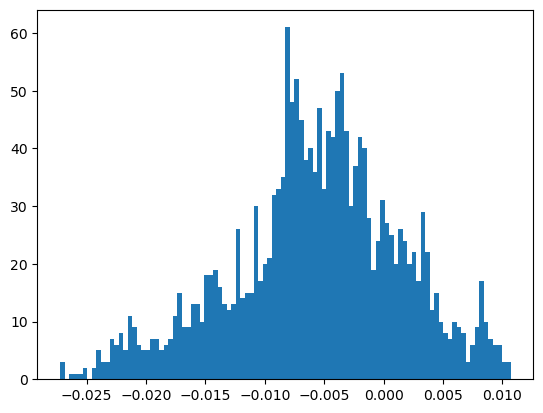

-0.00567687290721768


In [18]:
import matplotlib.pyplot as plt
window = KONVID_Saliency_feats
correlations = []

for i in range(KONVID_CNN_feats.shape[1] - window.shape[1] + 1):
    segment = KONVID_CNN_feats[:, i : i + window.shape[1]]
    correlation = np.corrcoef(window.flatten(), segment.flatten())[0, 1]
    correlations.append(correlation)

print(len(correlations))
# print(correlations)

plt.hist(correlations, bins=100)
plt.show()
print(np.mean(correlations))